# Import Packages

In [53]:
#--Basics---------------
import pandas as pd
import numpy as np

#--Data Visualization----
import matplotlib.pyplot as plt
import seaborn as sns

#---Scikit-Learn--------
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MaxAbsScaler, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression, Lasso
from sklearn.impute import SimpleImputer
from sklearn.utils import estimator_html_repr
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

#---Misc------------------
from mlxtend.feature_selection import SequentialFeatureSelector as MLSeqFeatSelector
from patsy import dmatrix
import statsmodels.api as sm


# Define Data

In [81]:
class MyData:
    def __init__(self, file, target_cols):
        df = pd.read_csv(file)
        cols_numeric, cols_categorical = self.numeric_categorical_attributes(df)
        self.df = df
        self.cols_numeric = cols_numeric
        self.cols_categorical = cols_categorical
        self.onehot_dict = {}
        self.label_dict = {}
        self.target_cols = target_cols

    def __str__(self):
        return str(self.df.head())
        
    def numeric_categorical_attributes(self, df):
        numeric, categorical = (set(), set())
        for col in df.columns:
            try:
                df[col].apply(pd.to_numeric)
                numeric.add(col)
            except:
                categorical.add(col)
        return (numeric, categorical)

    def clean_out(self, drop_cols):
        # Drop columns that have many nulls.
        new_df = self.df.drop(columns=drop_cols, axis=1)
        new_cols_numeric, new_cols_categorical = [cols.difference(drop_cols) for cols in [self.cols_numeric, self.cols_categorical]]
        # Impute missing values with the median of the respective column
        for col in new_cols_numeric:
            median_value = self.df[col].median()
            new_df[col] = self.df[col].fillna(median_value)  
        # Impute missing values with the mode of the respective column
        for col in new_cols_categorical:
            mode_value = self.df[col].mode()[0]
            new_df[col] = self.df[col].fillna(mode_value)
        self.df = new_df
        self.cols_numeric = new_cols_numeric
        self.cols_categorical = new_cols_categorical

    def filterByColumn(self, filter_dict, drop = False):
        for col in filter_dict.keys():
            self.df = self.df[self.df.apply(lambda x: x[col] in filter_dict[col], axis = 1)]
        if drop:
            drop_cols = list(filter_dict.keys())
            self.cols_numeric, self.cols_categorical = [cols.difference(drop_cols) for cols in [self.cols_numeric, self.cols_categorical]]
            self.df = self.df.drop(columns = list(filter_dict.keys()), axis = 1).reset_index(drop=True)

    def label_encoding(self, cols):
        label_dict = {}
        for col in cols: 
            unique_values = list(set(self.df[col]))
            label_dict[col] = unique_values
            map_value = {unique_values[i] : i for i in range(len(unique_values))}
            self.df[col] = self.df[col].map(map_value)
            self.cols_categorical = self.cols_categorical.difference({col})
            self.cols_numeric = self.cols_numeric.union({col})
        self.label_dict = self.label_dict | label_dict

    def onehot(self, cols = None):
        cols = self.cols_categorical if cols is None else cols
        onehot_dict = dict([(col, list(set(self.df[col]))) for col in cols])
        cols_numeric = self.cols_numeric
        cols_categorical = self.cols_categorical
        for col in onehot_dict.keys():
            cols_numeric = cols_numeric.union(set(["{}_{}".format(col, i) for i in onehot_dict[col]]))
            cols_categorical = cols_categorical.difference({col})
        encoder = OneHotEncoder(sparse_output = False).set_output(transform="pandas")
        X_ohe_cat = encoder.fit_transform(self.df[list(cols)])
        self.df = pd.concat([X_ohe_cat, self.df[list(set(self.df.columns).difference(cols))]], axis=1)
        self.cols_numeric = cols_numeric
        self.cols_categorical = cols_categorical
        self.onehot_dict = self.onehot_dict | onehot_dict

    def reverse_onehot(self, cols):
        for col in cols:
            categories = self.onehot_dict.pop(col)
            drop_cols = ["{}_{}".format(col, i) for i in categories]
            self.cols_numeric = self.cols_numeric.difference(set(drop_cols))
            self.cols_categorical = self.cols_categorical.union({col})
            df_cat = self.df.loc[:, drop_cols]
            n = range(len(drop_cols))
            mapping = dict(list(zip(tuple([tuple([int(i == j) for i in n]) for j in n]), categories)))
            self.df = pd.concat([self.df.drop(columns=drop_cols, axis=1), df_cat.index.to_series(name = col).map(lambda i: mapping[tuple(df_cat.loc[i, :])])], axis=1)

    def std_scaling(data, target):
        scaler = StandardScaler().set_output(transform="pandas")
        self.df = pd.concat([scaler.fit_transform(data.drop(target, axis=1)), data[target]], axis=1)

    def remake_column(self, col_number, newName, newValues = None, myFunc = None):
        oldName = self.df.columns[col_number]
        new_df = self.df.rename(columns = {oldName: newName})
        if newValues is not None:
            oldValues = np.sort(self.df.loc[:, oldName].unique())
            new_df[newName] = new_df[newName].map(dict(list(zip(oldValues, newValues))))
        else:
            new_df[newName] = new_df[newName].map(myFunc)
        if oldName in self.cols_numeric:
            self.cols_numeric = self.cols_numeric.difference({oldName}).union({newName})
        else:
            self.cols_categorical = self.cols_categorical.difference({oldName}).union({newName})
        self.df = new_df
        
    def histograms(self, features, size = 7):
        n = len(features)
        plt.figure(1, figsize = (size, size * n))
        for i in range(n):
            ax = plt.subplot(n, 1, i + 1)
            ax.title.set_text("Distribution of {}".format(features[i]))
            plt.hist(self.df[features[i]])
        plt.show()

    def pca_explained_var(self):
        variance_pca = []
        number_attributes = len(self.df.columns)
        pca = PCA(n_components=number_attributes)
        pca.fit(self.df)
        explained_variance = pca.explained_variance_ratio_
        for i in range(1, number_attributes):
            variance_list = list(explained_variance)[:i]
            variance_pca.append(sum(variance_list))
        plt.plot([i for i in range(0, number_attributes)], [0] + variance_pca, marker='o')
        plt.xlabel("Number of Principal Components")
        plt.ylabel("Explained Variance")
        plt.title("Number of Principle Components vs Explained Variance")
        plt.show()

## Main

In [83]:
data = MyData("Amazon Sales FY2020-21.csv", target_cols = ["County", "City", "State"])
data

C:\Users\Ian\AppData\Local\Temp\ipykernel_16684\2033187036.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


# Data Preparation

## Main

In [85]:
drop_columns = ["order_id", "order_date", "item_id", "sku", "bi_st", "payment_method", "cust_id", "Place Name", "month", "year", "ref_num", 'Name Prefix', "First Name", "Middle Initial", "Last Name", "full_name", "Sign in date", "E Mail", "Sign in date", "Phone No. ", "User Name"]
data.clean_out(drop_columns)
data.filterByColumn({"status": ["complete", "received"]}, drop=True)
data.label_encoding(["Gender"])
data.onehot(["Region"])
data.normalize()
data


KeyError: "['order_id', 'order_date', 'item_id', 'sku', 'bi_st', 'payment_method', 'cust_id', 'Place Name', 'month', 'year', 'ref_num', 'Name Prefix', 'First Name', 'Middle Initial', 'Last Name', 'full_name', 'Sign in date', 'E Mail', 'Sign in date', 'Phone No. ', 'User Name'] not found in axis"

# Exploratory Analysis

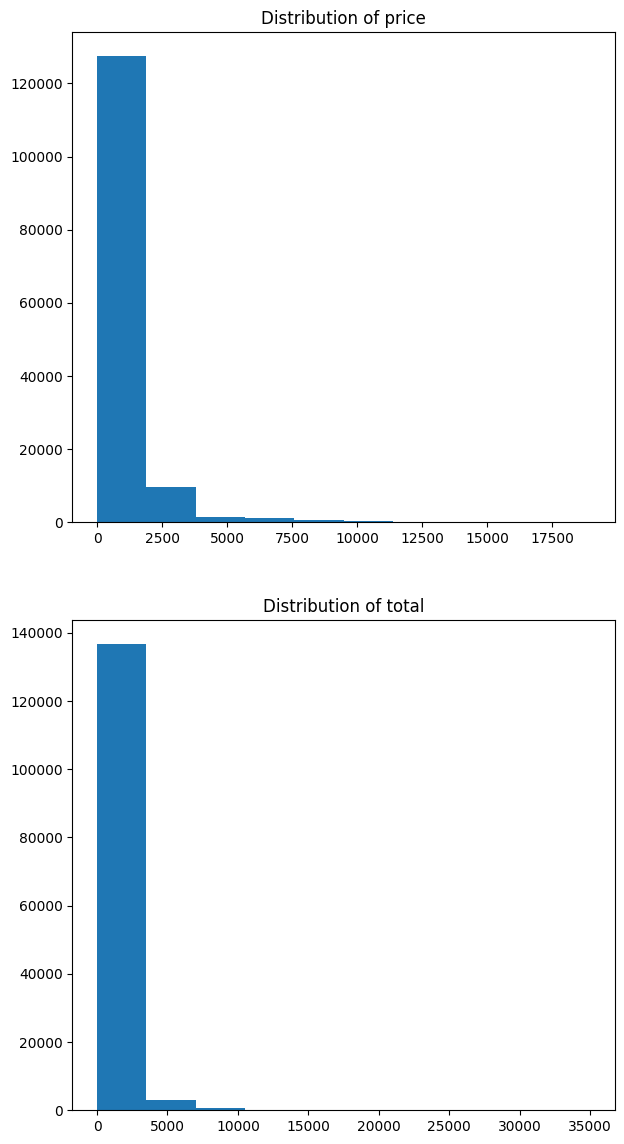

In [31]:
data.histograms(["price", "total"])

In [69]:
#data.pca_explained_var()

ValueError: could not convert string to float: '100468520-1'

# Clustering

In [46]:
def makeClusters(df, features, k, plot = None):
    X = df[features]
    model = KMeans(n_clusters=k, n_init="auto").fit(X)
    Y = pd.concat([df, pd.Series(data=model.predict(X), name = "Cluster")], axis = 1)
    if plot is None:
        return Y, model
    else:
        colors = np.linspace(0, 1, k)
        colordict = dict(zip(range(k), colors))
        Y["Color"] = Y["Cluster"].map(colordict)
        plt.scatter(x = Y[features[0]], y = X[features[1]], c = Y["Color"])
        plt.xlabel(plot[0])
        plt.ylabel(plot[1])
        plt.title("Data in {} Clusters".format(k))
        plt.show()

In [64]:
def knn_adv(train_df, test_df, cluster_features, target, k, target_weight_col = None):
    train_df_clus, model = makeClusters(train_df, cluster_features, k)
    clusters = pd.Series(data = model.predict(test_df), name = "Cluster")
    categories = train_df[target].unique()
    def category_dist(j):
        cluster_df = train_df_clus.loc[lambda df: df["Cluster"] == clusters[j]].drop(columns = ["Cluster"])
        knn_weight = lambda i: 1/np.sqrt(2 * np.pi) * np.exp((-(np.linalg.norm(cluster_df.loc[i, cluster_features] - test_df.loc[j, cluster_features])) ** 2)/2)
        target_weight = np.ones(cluster_df.shape[0]) if target_weight_col is None else cluster_df.index.to_series().map(lambda i: 1)
        print(target_weight)
        cluster_df["Weight"] = cluster_df.index.map(lambda i: knn_weight(i) * target_weight[i])
        category_series = cluster_df[[target, "Weight"]].groupby(by=[target]).sum()["Weight"]
        total_weight = sum(category_series)
        category_series_complete = pd.concat([category_series, pd.Series(dict([(c, 0) for c in set(categories).difference(category_series.index)]))]).sort_index()
        return category_series_complete.map(lambda w: w / total_weight)
    data = dict([(j, list(category_dist(j))) for j in test_df.index])
    cat_df = pd.DataFrame.from_dict(data = data, columns = ["{}_{}".format(target, c) for c in categories], orient="index")
    return pd.concat([test_df, cat_df], axis=1)

In [65]:
test_df = pd.DataFrame({"Gender": [1, 1], "age": [43, 43]})
data.reverse_onehot(["category"])
df = knn_adv(data.df, test_df, ["Gender", "age"], "category", 20, "total")

0         1
1         1
2         1
3         1
4         1
         ..
140616    1
140658    1
140659    1
140660    1
140661    1
Length: 6595, dtype: int64
0         1
1         1
2         1
3         1
4         1
         ..
140616    1
140658    1
140659    1
140660    1
140661    1
Length: 6595, dtype: int64


,Gender,age,category_Men's Fashion,category_Appliances,category_Home & Living,category_Mobiles & Tablets,category_Beauty & Grooming,category_Health & Sports,category_Women's Fashion,category_Soghaat,category_Kids & Baby,category_Superstore,category_Entertainment,category_Computing,category_Others,category_Books,category_School & Education
0,1,43,0.119213,0.076432,0.003552,0.028636,0.072216,0.025628,0.051292,0.031447,0.156524,0.181337,0.054167,0.005745,0.025791,0.055023,0.112997
1,1,43,0.119213,0.076432,0.003552,0.028636,0.072216,0.025628,0.051292,0.031447,0.156524,0.181337,0.054167,0.005745,0.025791,0.055023,0.112997
